# Classification and Regression Diffusion (CARD) Model

## Theoretic Foundation

## Outline

We will begin with a standard toy regression example and show you you can quantify uncertainty with the CARD approach. For this we will place a Gaussian Assumption on the model, which is not theoretical necessary but can be useful when comparing it for a standard toy regression problem. However, we will also show an example that demonstrates the expressiveness of CARD by reproducing the 8 Gaussians example (Figure 1) from the original paper by [Han et al. 2022](https://arxiv.org/abs/2206.07275), which shows the strong capabilities of recovering the true data distribution.

## Imports

In [7]:
import os
import sys
import torch

import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from torch.optim import Adam

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule, ToyDonutDataModule
from lightning_uq_box.models import MLP, ConditionalGuidedLinearModel
from lightning_uq_box.uq_methods import CARDRegression, DeterministicRegression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

In [9]:
dm = ToyHeteroscedasticDatamodule(n_train=1000)

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)


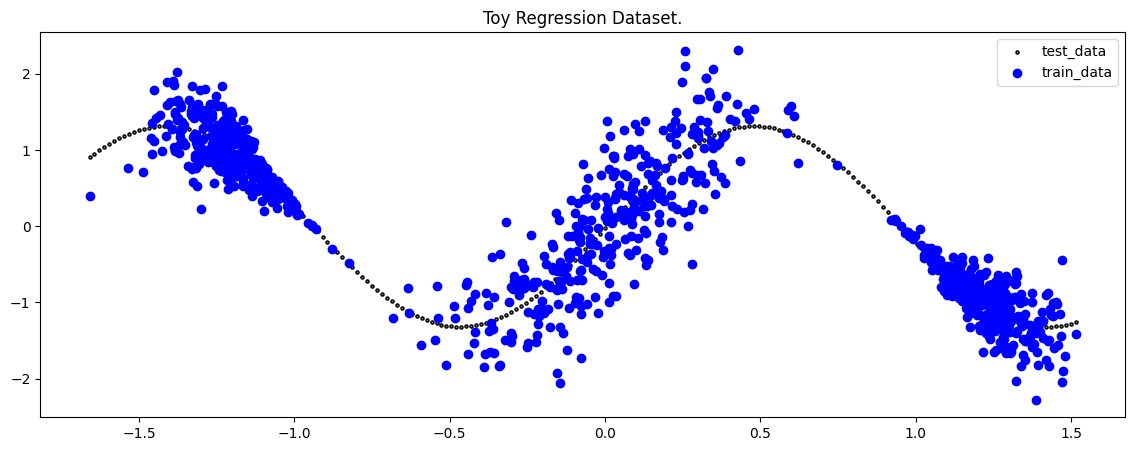

In [10]:
plot_toy_regression_data(X_train, y_train, X_test, y_test)


# Model

For CARD, we need to pretrain a conditional mean estimation model before moving to diffusion training stage. Here, we will do this with a simple MLP and train it using the `DeterminisitcRegression` module.


In [11]:
network = MLP(n_inputs=1, n_hidden=[50, 50], n_outputs=1)

cond_mean_model = DeterministicRegression(
    model=network,
    optimizer=partial(torch.optim.Adam, lr=1e-2),
    loss_fn=nn.MSELoss()
)

trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    accelerator="cpu",
    enable_checkpointing=False,
    enable_progress_bar=False,
)
trainer.fit(cond_mean_model, dm)

/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-p ...
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Missing logger folder: /mnt/SSD2/nils/projects/lightning-uq-box/docs/tutorials/regression/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 2.7 K 
1 | loss_fn       | MSELoss          | 0     
2 | train_metrics | M

We can plot the predictions of the pretrained model, which as a deterministic point network has no uncertainty estimate for its predictions.

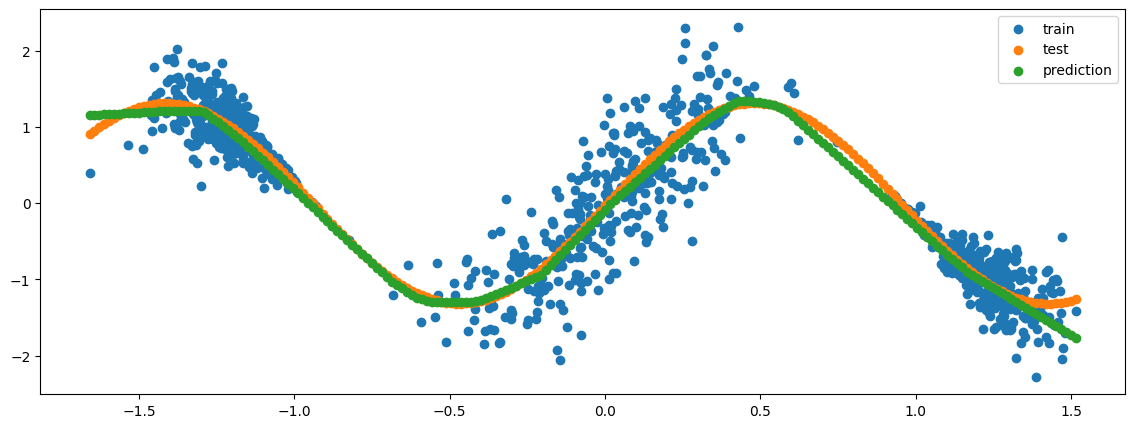

In [12]:
preds = cond_mean_model.predict_step(X_test)
fig, ax = plt.subplots(1)
ax.scatter(X_train, y_train, label="train")
ax.scatter(X_test, y_test, label="test")
ax.scatter(X_test, preds["pred"], label="prediction")
plt.legend()

## Diffusion Model

Given the deterministic conditional mean model, we can now move towards the diffusion modelling stage. For the guidance model we also select a simple Linear model.

In [15]:
# configuration parameters

n_steps = 1000
cat_x = True
cat_y_pred = True

x_dim = 1
y_dim = 1

n_hidden = [128, 128]

In [15]:
guidance_model = ConditionalGuidedLinearModel(
    n_steps=n_steps,
    x_dim=x_dim,
    y_dim=y_dim,
    n_hidden=n_hidden,
    cat_x=cat_x,
    cat_y_pred=cat_y_pred,
)

In [16]:
card_model = CARDRegression(
    cond_mean_model=cond_mean_model.model,
    guidance_model=guidance_model,
    guidance_optim=partial(torch.optim.Adam, lr=1e-2),
    n_steps=n_steps,
)


> **_NOTE:_**  Dffusion modelling is computationally heavier than many other approaches, and is best done on a GPU. You can open this notebook in a google colab environment to access a GPU and experiment yourself (rocket icon button at top of the page).

In [17]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logger = CSVLogger(my_temp_dir)
diff_trainer = Trainer(
    max_epochs=1000,  # number of epochs we want to train
    accelerator="gpu",
    devices=[0],
    logger=logger,
    log_every_n_steps=10,
    enable_checkpointing=False,
    enable_progress_bar=False,
)
diff_trainer.fit(card_model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /tmp/tmpx1gxvbyf/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | cond_mean_model | MLP                          | 2.7 K 
1 | guidance_model  | ConditionalGuidedLinearModel | 273 K 
2 | train_metrics   | MetricCollection             | 0     
3 | val_metrics     | MetricCollection             | 0     
4 | test_metrics    | MetricCollection             | 0     
-----------------------------------------------------------------
275 K     Trainable params
0         Non-trainable params
275 K     Total params
1.103     Total estimated model params size (MB)
/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/nils/.con

## Training metrics

We can check the convergence by inspecting the loss over epochs

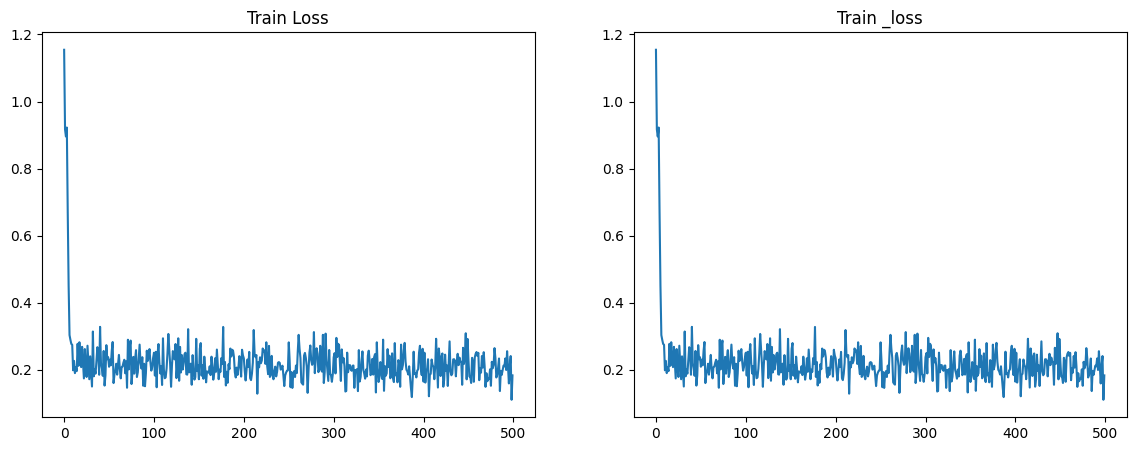

In [19]:
fig = plot_training_metrics(os.path.join(my_temp_dir, "lightning_logs"), "_loss")

# Prediction

In [23]:
card_model = card_model.to("cuda")
preds = card_model.predict_step(X_test.cuda())

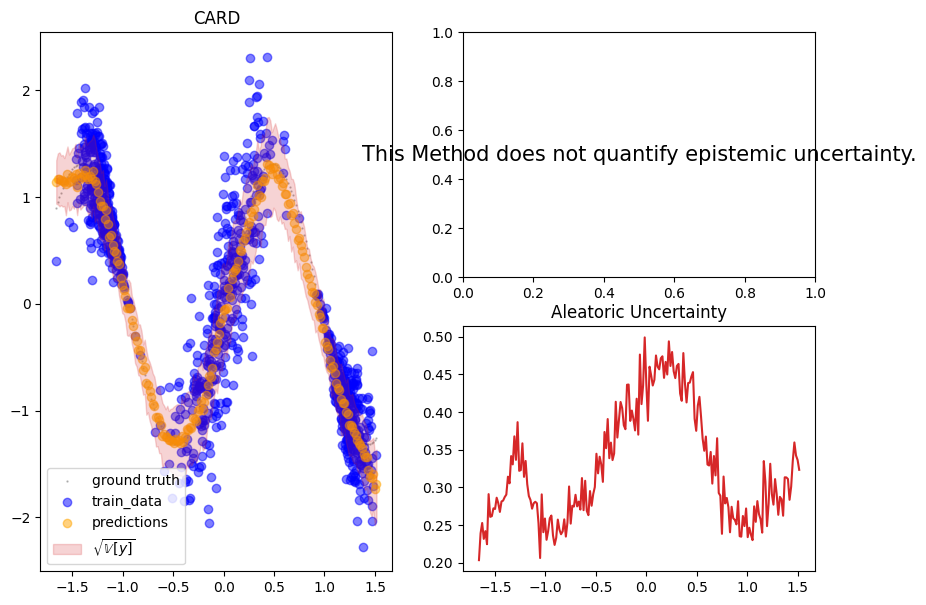

In [24]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="CARD",
    show_bands=False,
)

In this example, we placed a Gaussian assumption on the model outputs, as we did moment matching of the CARD samples to get an estimate of predictive uncertainty. This is restrictive and theoretically not necessary for CARD. We will demonstrate this with another example, the 8 Gaussians toy example. The majority of UQ-Methods won't be able to solve this task as they inherently have a Gaussian assumption for their predictive uncertainty estimates, so this is a nice example of CARD's capabilities.

## Toy 8 Gaussians example

## Datamodule

In [8]:
dm = ToyDonutDataModule(batch_size=256)

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)


In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([2000]), torch.Size([2000]), torch.Size([800]), torch.Size([800]))

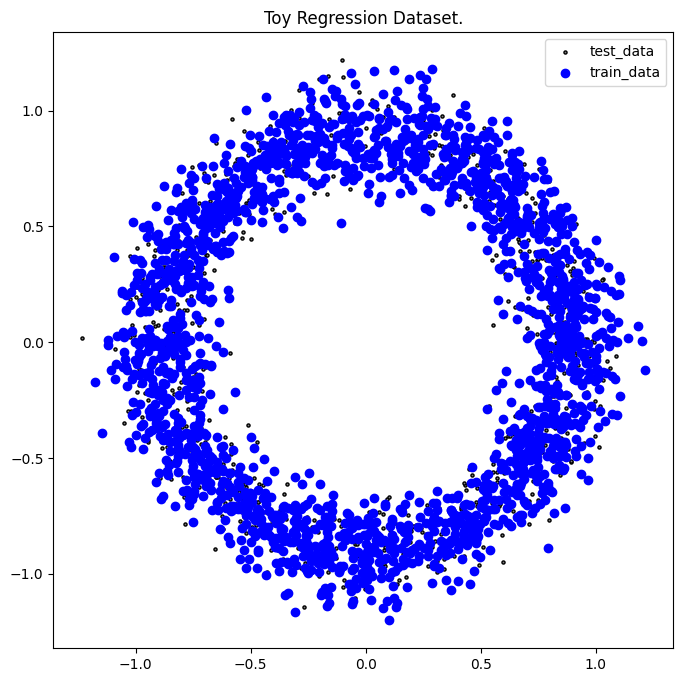

In [11]:
plt.rcParams["figure.figsize"] = [8, 8]
plot_toy_regression_data(X_train, y_train, X_test, y_test)
plt.rcParams["figure.figsize"] = [14, 5]

# Training

Fitting a deterministic base model.

In [13]:
another_temp_dir = tempfile.mkdtemp()
network = MLP(n_inputs=1, n_hidden=[50, 50], n_outputs=1)

cond_mean_model = DeterministicRegression(
    model=network,
    optimizer=partial(torch.optim.Adam, lr=1e-2),
    loss_fn=nn.MSELoss()
)

trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    devices=[0],
    accelerator="gpu",
    enable_checkpointing=False,
    enable_progress_bar=True,
)
trainer.fit(cond_mean_model, dm)

/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 2.7 K 
1 | loss_fn       | MSELoss          | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 8/8 [00:00<00:00, 52.95it/s, v_num=17] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 8/8 [00:00<00:00, 48.44it/s, v_num=17]


In [16]:
guidance_model = ConditionalGuidedLinearModel(
    n_steps=n_steps,
    x_dim=x_dim,
    y_dim=y_dim,
    n_hidden = [128, 128, 128],
    cat_x=cat_x,
    cat_y_pred=cat_y_pred,
)

card_model = CARDRegression(
    cond_mean_model=cond_mean_model.model,
    guidance_model=guidance_model,
    guidance_optim=partial(torch.optim.Adam, lr=1e-3),
    n_steps=n_steps,
)

In [17]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logger = CSVLogger(another_temp_dir)
diff_trainer = Trainer(
    max_epochs=1000,  # number of epochs we want to train
    accelerator="gpu",
    devices=[0],
    logger=logger,
    log_every_n_steps=4,
    enable_progress_bar=True,
)
diff_trainer.fit(card_model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmp7b7_w6uc/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | cond_mean_model | MLP                          | 2.7 K 
1 | guidance_model  | ConditionalGuidedLinearModel | 417 K 
2 | train_metrics   | MetricCollection             | 0     
3 | val_metrics     | MetricCollection             | 0     
4 | test_metrics    | MetricCollection             | 0     
-----------------------------------------------------------------
420 K     Trainable params
0         Non-trainable params
420 K     Total params
1.681     Total estimated model params size (MB)


Epoch 999: 100%|██████████| 8/8 [00:00<00:00, 70.88it/s, v_num=0]          

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 8/8 [00:00<00:00, 65.21it/s, v_num=0]


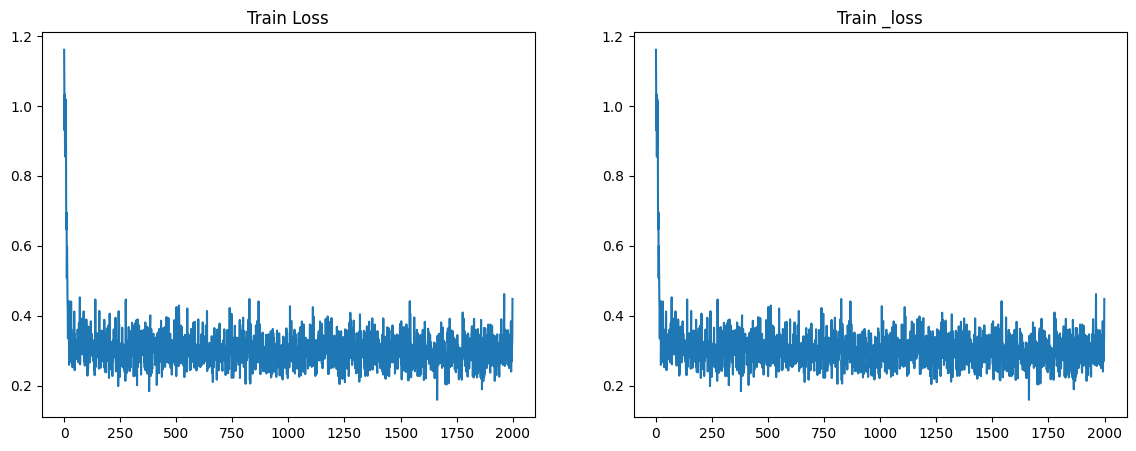

In [18]:
fig = plot_training_metrics(os.path.join(another_temp_dir, "lightning_logs"), "_loss")

## Prediction

We will now plot the generate samples of the Diffusion model to demonstrate how it actually recovers the 8 Gaussian bumps.

In [20]:
card_model = card_model.to("cuda")
preds = card_model.predict_step(X_test.unsqueeze(-1).cuda())

# samples of the last diffusion step (n_samples, n_test_points, y_dim)
samples = preds["samples"][-1].detach().cpu().numpy()


In [21]:
samples.squeeze(-1).transpose(1,0).shape, X_test.shape

((800, 100), torch.Size([800]))

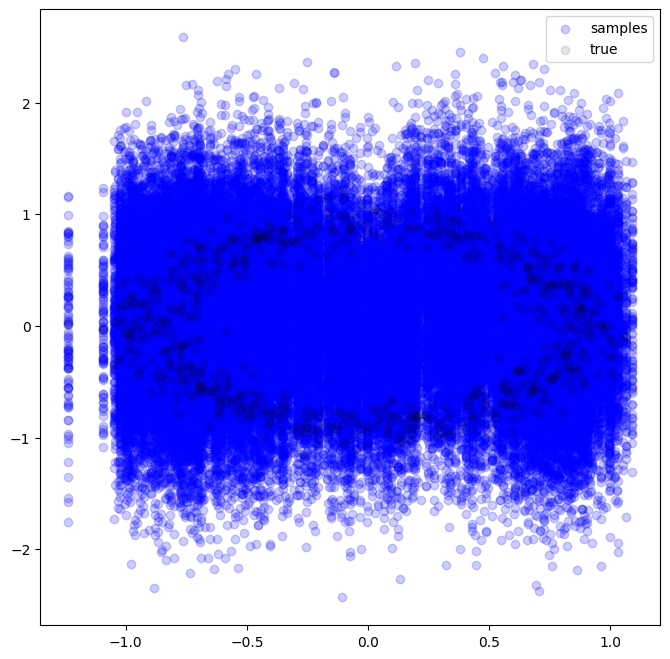

In [22]:
fig, axs = plt.subplots(1, figsize=(8, 8))


axs.scatter(X_test.tile(dims=(card_model.n_z_samples,1)), samples.squeeze(), alpha=0.2, color="blue", label="samples")
axs.scatter(X_test, y_test, label="true", alpha=0.1, color="black")
plt.legend()
